In [1]:
from google.cloud import language_v1
import pandas as pd
import json
import os
import time
import matplotlib.pyplot as plt

In [ ]:
OUTDIR = 'workspace/02-entity-sentiment'
os.makedirs(OUTDIR, exist_ok=True)

In [2]:
neutral_range = 0.1

In [3]:
def analyze_entity_sentiment(text_content):
    """
    Analyzing Entity Sentiment in a String

    Args:
      text_content The text content to analyze
    """

    client = language_v1.LanguageServiceClient()

    # text_content = 'Grapes are good. Bananas are bad.'

    # Available types: PLAIN_TEXT, HTML
    type_ = language_v1.types.Document.Type.PLAIN_TEXT

    # Optional. If not specified, the language is automatically detected.
    # For list of supported languages:
    # https://cloud.google.com/natural-language/docs/languages
    language = "ja"
    document = {"content": text_content, "type_": type_, "language": language}

    # Available values: NONE, UTF8, UTF16, UTF32
    encoding_type = language_v1.EncodingType.UTF8

    response = client.analyze_entity_sentiment(
        request={"document": document, "encoding_type": encoding_type}
    )
    
    # Loop through entitites returned from the API
    li = []
    for entity in response.entities:
        entity_type = language_v1.Entity.Type(entity.type_).name

        polarity = "neutral"
        if entity.sentiment.score > neutral_range:
            polarity = "positive"
        elif entity.sentiment.score < -neutral_range:
            polarity = "negative"
        
        li.append([entity.name, entity_type, entity.sentiment.score, polarity])

    return li

In [4]:
def cal_price(input_text):
    # テキストの文字数を取得
    num_chars = len(input_text)
    
    # 1,000文字ごとに1ユニット、端数は切り上げ
    num_units = -(-num_chars // 1000)  # 切り上げの計算

    # ユニット数に応じた料金計算
    if num_units <= 5000:
        price_per_unit = 2.00  # 0～5,000ユニット
    elif num_units <= 1000000:
        price_per_unit = 1.00  # 5,001～1,000,000ユニット
    elif num_units <= 5000000:
        price_per_unit = 0.50  # 1,000,001～5,000,000ユニット
    else:
        price_per_unit = 0.25  # 5,000,001ユニット以上

    # 総料金を計算
    total_price = num_units * price_per_unit / 1000  # 1,000ユニットあたりの料金なので調整

    return total_price


# メイン処理

In [5]:
target_dir = 'workspace/01-reviews/'

In [6]:
max_count_to_call = float('inf')
# max_count_to_call = 3

In [7]:
def iter_reviews():
    count_to_call = 0

    for entry in os.listdir(target_dir):
        full_path = os.path.join(target_dir, entry)

        with open(full_path, "r", encoding="utf-8") as f:
            reviews = json.load(f)
            for review in reviews:
                count_to_call += 1
                if count_to_call > max_count_to_call:
                    return
                yield review

## 料金確認

In [8]:
prices = [cal_price(review) for review in iter_reviews()]
len_reviews = len(prices)
print("$", sum(prices))
del prices

$ 5.0680000000000005


## Entity感情分析

In [9]:
entities = []
process_times = []
for i, review in enumerate(iter_reviews()):
    start = time.time()
    entities.extend(analyze_entity_sentiment(review))
    process_times.append(time.time() - start)
    print(f"\r{i+1} / {len_reviews}", end="")

868 / 2534

I0000 00:00:1739710335.327944 1937014 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


2534 / 2534

In [10]:
columns = ["entityName", "type", "score", "polarity"]
df = pd.DataFrame(data=entities, columns=columns)
df

,entityName,type,score,polarity
0,購入,EVENT,0.0,neutral
1,目,OTHER,0.0,neutral
2,病気,OTHER,0.0,neutral
3,家電量販店,LOCATION,0.2,positive
4,ボタン,OTHER,0.0,neutral
...,...,...,...,...
15649,感じ,OTHER,0.3,positive
15650,風量,OTHER,0.0,neutral
15651,野外向き,LOCATION,0.0,neutral
15652,Anker,OTHER,0.0,neutral


In [ ]:
df.to_csv(f'{OUTDIR}/entity-sentiment.csv', index=False)

# 呼び出し時間

In [12]:
sum(process_times) / len(process_times)

2.485662751058565

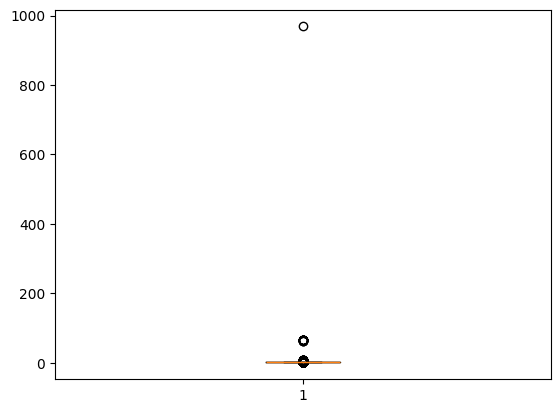

In [13]:
plt.boxplot(process_times)
plt.show()

In [5]:
review = """
安いわりにはおいしい。
このクオリティにしては安すぎるぐらいです！
"""
analyze_entity_sentiment(review)

[['クオリティ', 'OTHER', 0.20000000298023224, 'positive']]